# PREPROCESSING

ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [1]:
# Parameters
SEQ_LEN = 24  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
EPOCHS = 30 
BATCH_SIZE = 32

# VMD parameters
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7
K_hat = 8                  # number of VMD modes (tuneable)
alpha_hat = 1705             # VMD alpha (tuneable)
tau_hat = 0.05805898025979961                # VMD tau

LSTM_UNITS = 128
DROPOUT = 0.2
LEARNING_RATE = 1e-3

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Softmax
from vmdpy import VMD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout,Bidirectional, Layer,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import random
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Concatenate


2025-11-23 13:40:37.944670: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 13:40:38.065605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763892638.107404    3696 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763892638.120979    3696 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-23 13:40:38.234516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
save_dir = os.path.expanduser("~/Project/AttnLstm/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


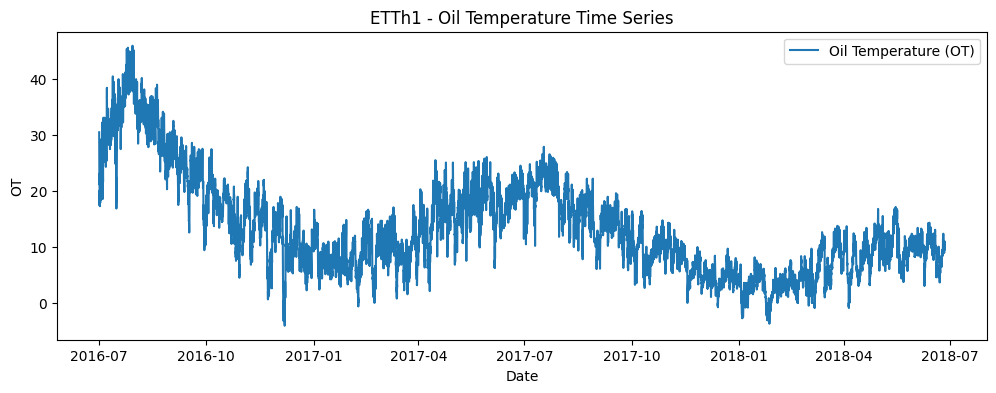

In [4]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split Simple

In [5]:
# =====================================================
# Split Train/Test
# =====================================================
split_idx = int(len(df) * 0.8)
train_data = df[:split_idx]
test_data  = df[split_idx:]
# =====================================================
# Helper for VMD-based training data
# =====================================================
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    limit = min(len(X), len(y)) - seq_len
    for i in range(limit):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

    
def train_test(alpha=1, tau=1, K=1):
    # --- VMD on train and test ---
    u_train, _, _ = VMD(train_data[TARGET_COL].values, alpha, tau, K, DC=0, init=1, tol=1e-7)
    u_test,  _, _ = VMD(test_data[TARGET_COL].values,  alpha, tau, K, DC=0, init=1, tol=1e-7)

    vmd_train = np.stack(u_train, axis=1)
    vmd_test  = np.stack(u_test,  axis=1)

    # --- Scale features & target ---
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    train_scaled_vmd = scaler_x.fit_transform(vmd_train)
    train_scaled_target = scaler_y.fit_transform(train_data[[TARGET_COL]])
    test_scaled_vmd  = scaler_x.transform(vmd_test)
    test_scaled_target  = scaler_y.transform(test_data[[TARGET_COL]])

    # --- Sequence generation (aligned) ---
    X_train_vmd, y_train_vmd = create_sequences(train_scaled_vmd, train_scaled_target, SEQ_LEN)
    X_test_vmd,  y_test_vmd  = create_sequences(test_scaled_vmd,  test_scaled_target,  SEQ_LEN)
    X_train_simple, y_train_simple = create_sequences(train_scaled_target,train_scaled_target,SEQ_LEN)
    X_test_simple, y_test_simple = create_sequences(test_scaled_target,test_scaled_target,SEQ_LEN)
    y_test_simple_true = scaler_y.inverse_transform(y_test_simple.reshape(-1, 1)).flatten()
    y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)

    return y_test_vmd_true,y_test_simple_true,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,X_train_simple,y_train_simple,X_test_simple,y_test_simple



## Attention and Xlstm layers

In [6]:
# =====================================================
# 2️⃣ Bahdanau-style Attention Layer
# =====================================================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)   # (batch, time, features)
        a_it = tf.tensordot(u_it, self.u, axes=1)                  # (batch, time)
        a_it = tf.nn.softmax(a_it, axis=1)                         # (batch, time)
        a_it = tf.expand_dims(a_it, axis=-1)                       # (batch, time, 1)
        weighted_output = x * a_it                                  # (batch, time, features)
        return tf.reduce_sum(weighted_output, axis=1)              # (batch, features)

    def compute_output_shape(self, input_shape):
        # output shape: (batch, features)
        return (input_shape[0], input_shape[2])

def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

# ========================================
# 📌     XLSTM LAYER
# ========================================
class XLSTM(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(XLSTM, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)

# =========================================================
# 📌  Custom Luong Attention
# score = h_t · W · h_s  (dot-product)
# =========================================================
class LuongAttention(Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wv = Dense(units)

    def call(self, query, value, mask=None):
        # Project both → SAME dimension
        q = self.Wq(query)      # (B, T, units)
        v = self.Wv(value)      # (B, T, units)

        # Dot product score
        score = tf.matmul(q, v, transpose_b=True)  # (B, T, T)

        if mask is not None:
            score += (mask * -1e9)

        # Use tf.nn.softmax (Keras-safe)
        attn_weights = tf.nn.softmax(score, axis=-1)     # (B, T, T)
        context = tf.matmul(attn_weights, v)             # (B, T, units)

        return context

# =========================================================
# 📌  Temporal Attention (per timestep)
# =========================================================
class TemporalAttention(Layer):
    def __init__(self, units):
        super().__init__()
        self.Wt = Dense(units)
        self.vt = Dense(1)

    def call(self, x):
        h = tf.nn.tanh(self.Wt(x))
        score = self.vt(h)
        alpha = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(alpha * x, axis=1)
        return context


# =========================================================
# 📌  Cross-Attention (Query from XLSTM, Key/Value from VMD input)
# =========================================================
class CrossAttention(Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, context, mask=None):
        return self.mha(query=query, value=context, key=context, attention_mask=mask)


# =========================================================
# 📌  Causal Masking (prevent future leakage)
# =========================================================
def causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[None, None, :, :]

      

# AttnLSTM+VMD


I0000 00:00:1763892646.337626    3696 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21477 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 122)        │        63,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 122)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 122)            │        15,128 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 122)            │       119,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,553 (806.85 KB)

 Trainable params: 206,553 (806.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


I0000 00:00:1763892648.010211    3946 cuda_dnn.cc:529] Loaded cuDNN version 90300


435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0142 - mae: 0.0749 - val_loss: 5.7066e-04 - val_mae: 0.0180
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - mae: 0.0248 - val_loss: 2.3156e-04 - val_mae: 0.0114
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.4471e-04 - mae: 0.0192 - val_loss: 2.1712e-04 - val_mae: 0.0116
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4.9499e-04 - mae: 0.0168 - val_loss: 1.3389e-04 - val_mae: 0.0087
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4.4392e-04 - mae: 0.0160 - val_loss: 2.8810e-04 - val_mae: 0.0144
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3.5531e-04 - mae: 0.0143 - val_loss: 9.3708e-05 - val_mae: 0.0074
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3.2230e-04 - mae: 0.0136 - val_loss: 1.0074e-04 - val_mae: 0.0078
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 2.7596e-04 - mae: 0.0125 - val_loss: 9.1197e-05 - val_mae: 0.0071
Epo

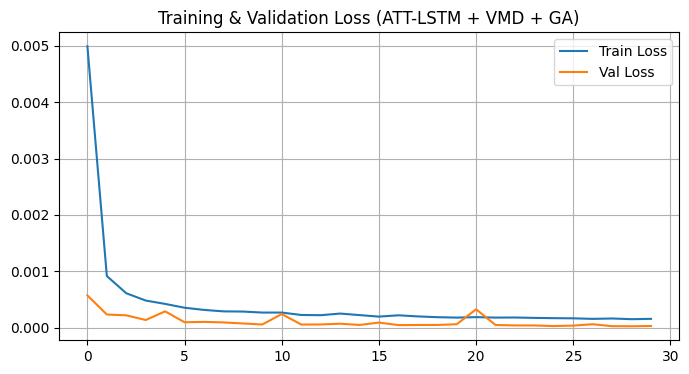

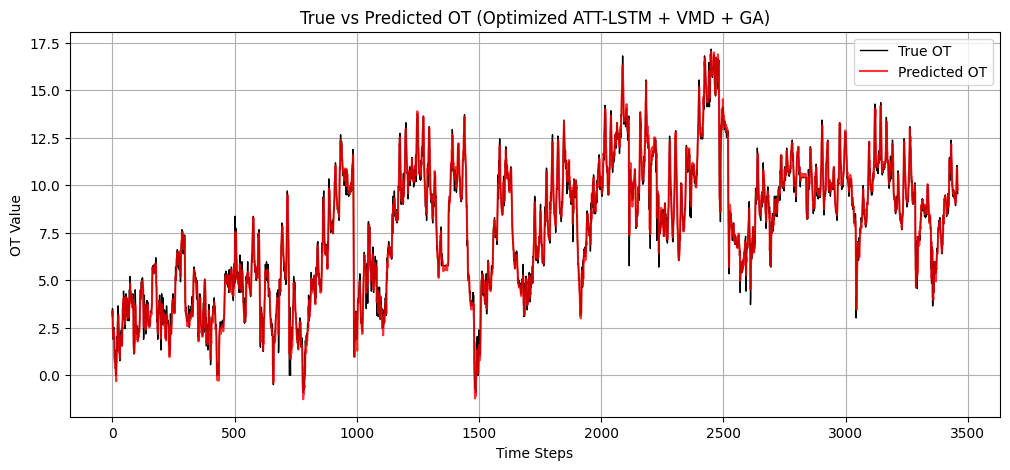

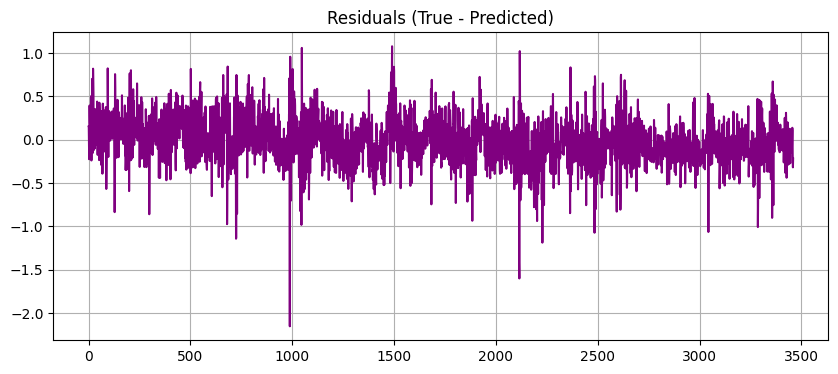

In [7]:
y_test_vmd_true,_,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=122,
    lstm2_units=122,
    dense_units=64
)
model.summary()

history_attlstm_vmd_ga = model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_attlstm_vmd_ga_scaled = model.predict(X_test_vmd)
y_pred_attlstm_vmd_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_vmd_ga.history['loss'], label='Train Loss')
plt.plot(history_attlstm_vmd_ga.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + VMD + GA)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + VMD + GA)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_attlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


# AttnLSTM+SIMPLE

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 122)        │        60,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 122)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ (None, 122)            │        15,128 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 122)            │       119,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,137 (793.50 KB)

 Trainable params: 203,137 (793.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0143 - mae: 0.0732 - val_loss: 0.0012 - val_mae: 0.0257
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0026 - mae: 0.0384 - val_loss: 6.8647e-04 - val_mae: 0.0193
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0016 - mae: 0.0306 - val_loss: 4.9571e-04 - val_mae: 0.0166
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0011 - mae: 0.0248 - val_loss: 3.0917e-04 - val_mae: 0.0126
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8.9566e-04 - mae: 0.0221 - val_loss: 2.3728e-04 - val_mae: 0.0107
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 7.5277e-04 - mae: 0.0201 - val_loss: 2.6757e-04 - val_mae: 0.0121
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6.9887e-04 - mae: 0.0193 - val_loss: 2.1908e-04 - val_mae: 0.0105
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.4453e-04 - mae: 0.0188 - val_loss: 2.1605e-04 - val_mae: 0.0105
Epoc

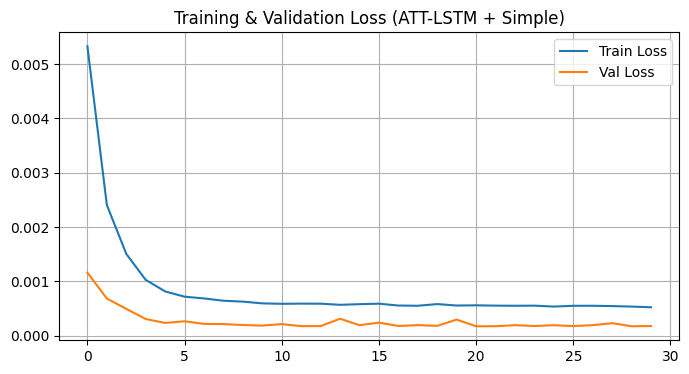

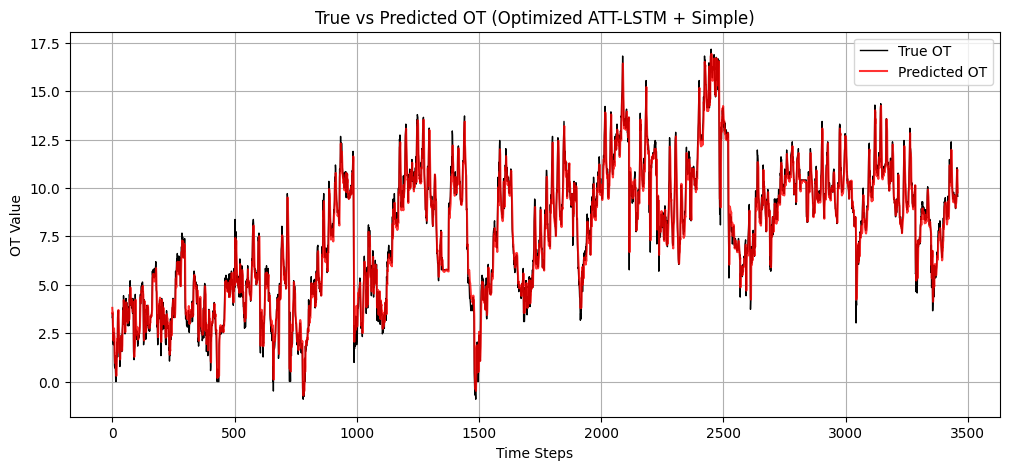

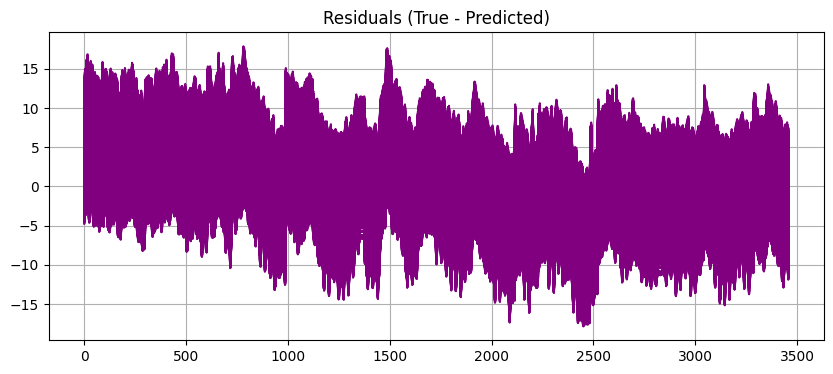

In [8]:
_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 

model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_simple.shape[-1]),
    lstm1_units=122,
    lstm2_units=122,
    dense_units=64
)

model.summary()

history_attlstm_simple = model.fit(
    X_train_simple, y_train_simple,
    validation_data=(X_test_simple, y_test_simple),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_simple_ga_scaled = model.predict(X_test_simple)
y_pred_attlstm_simple_true = scaler_y.inverse_transform(y_pred_attlstm_simple_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_simple.history['loss'], label='Train Loss')
plt.plot(history_attlstm_simple.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + Simple)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_simple_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + Simple)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_simple_true - y_pred_attlstm_simple_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

# BidirectionalLSTM_SIMPLE

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 24, 256)        │       140,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,537 (1.29 MB)

 Trainable params: 337,537 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0099 - mae: 0.0572 - val_loss: 3.5833e-04 - val_mae: 0.0139
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0013 - mae: 0.0271 - val_loss: 2.8869e-04 - val_mae: 0.0124
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 3.9913e-04 - val_mae: 0.0159
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 9.4643e-04 - mae: 0.0229 - val_loss: 3.8810e-04 - val_mae: 0.0162
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 8.7297e-04 - mae: 0.0218 - val_loss: 1.9734e-04 - val_mae: 0.0098
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 7.5644e-04 - mae: 0.0204 - val_loss: 2.4562e-04 - val_mae: 0.0118
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 7.2676e-04 - mae: 0.0198 - val_loss: 1.9301e-04 - val_mae: 0.0098
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.7384e-04 - mae: 0.0188 - val_loss: 2.1595e-04 - val_mae: 0.0

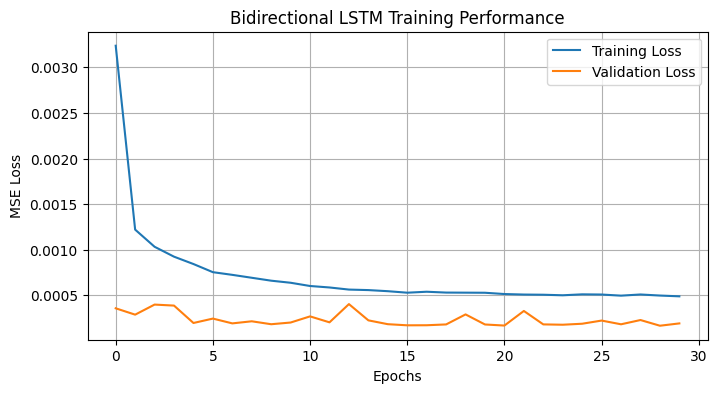

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


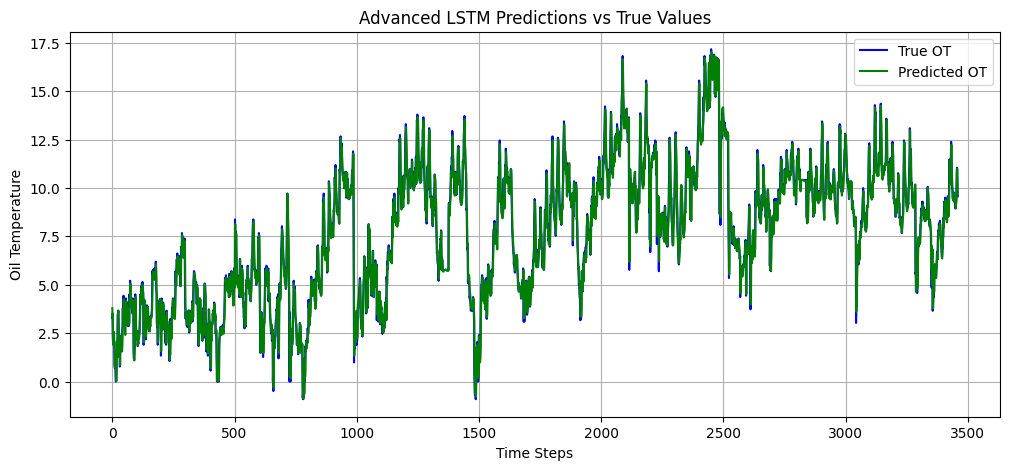

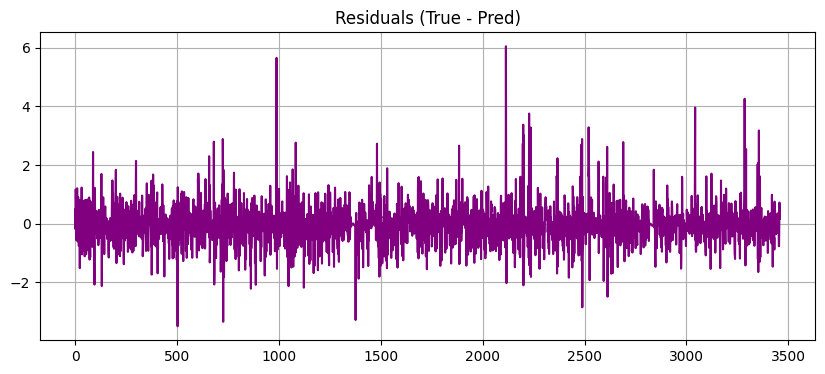

In [9]:
_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 

# ---------------------------
# 5. Build Bidirectional_LSTM model
# ---------------------------
def build_Bidirectional_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

Bidirectional_lstm = build_Bidirectional_lstm_model((SEQ_LEN, K_hat),128)
Bidirectional_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_Bidirectional_lstm_simple = Bidirectional_lstm.fit(
    X_train_simple, y_train_simple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test_simple),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_Bidirectional_lstm_simple.history['loss'], label='Training Loss')
plt.plot(history_Bidirectional_lstm_simple.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Bidirectional LSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_scaled_Bidirectional_lstm = Bidirectional_lstm.predict(X_test_simple)
y_pred_Bidirectional_lstm_simple_true = scaler_y.inverse_transform(y_pred_scaled_Bidirectional_lstm.reshape(-1, 1)).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_Bidirectional_lstm_simple_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_pred_Bidirectional_lstm_simple_true - y_test_simple_true
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

# LSTM_VMD

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,857 (788.50 KB)

 Trainable params: 201,857 (788.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0092 - mae: 0.0568 - val_loss: 1.2453e-04 - val_mae: 0.0083
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.5068e-04 - mae: 0.0234 - val_loss: 8.2003e-05 - val_mae: 0.0067
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6.7313e-04 - mae: 0.0197 - val_loss: 7.0741e-05 - val_mae: 0.0062
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.8667e-04 - mae: 0.0184 - val_loss: 1.8369e-04 - val_mae: 0.0115
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.4156e-04 - mae: 0.0175 - val_loss: 7.9339e-05 - val_mae: 0.0068
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.9202e-04 - mae: 0.0165 - val_loss: 4.6893e-05 - val_mae: 0.0050
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.3469e-04 - mae: 0.0156 - val_loss: 6.0992e-05 - val_mae: 0.0061
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3.3681e-04 - mae: 0.0136 - val_loss: 4.4937e-05 - val_

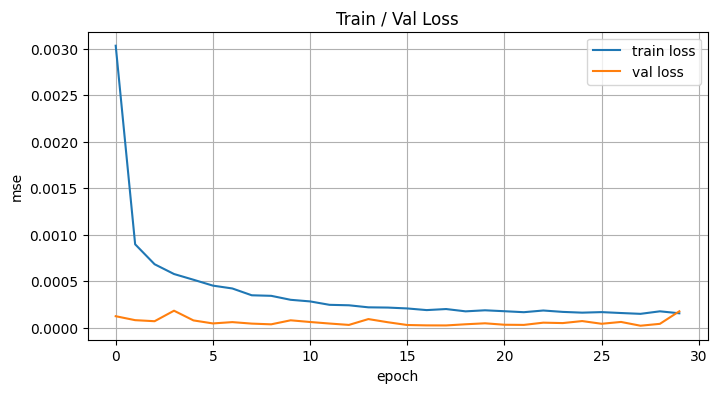

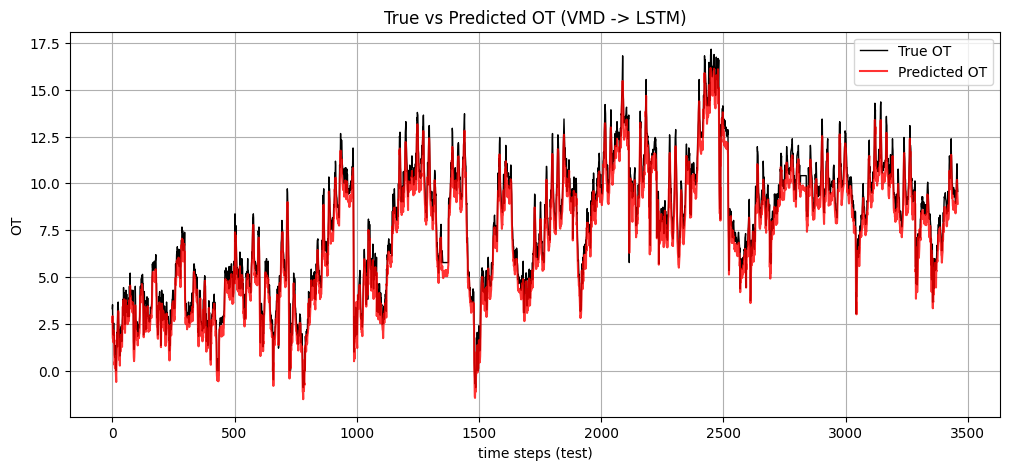

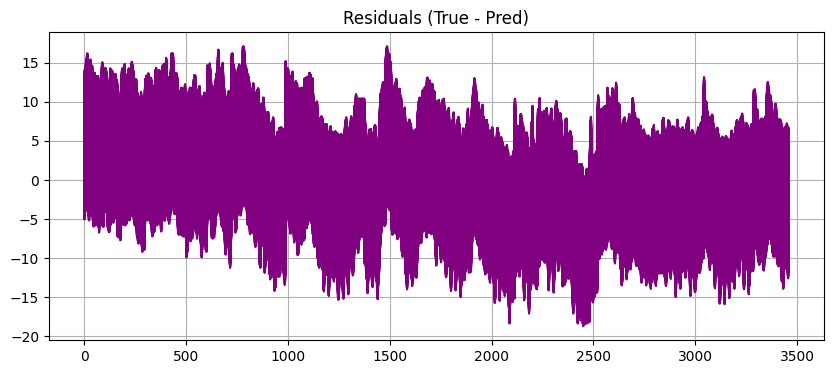

In [10]:
y_test_vmd_true,_,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

# ---------------------------
# 5. Build LSTM model
# ---------------------------
def build_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

model = build_lstm_model((SEQ_LEN, K_hat),128)
model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm_vmd = model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_vmd_scaled = model.predict(X_test_vmd)
y_pred_lstm_vmd_true = scaler_y.inverse_transform(y_pred_lstm_vmd_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_lstm_vmd.history['loss'], label='train loss')
plt.plot(history_lstm_vmd.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_lstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (VMD -> LSTM)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_pred_lstm_vmd_true - y_test_vmd_true
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()


# XLSTM_VMD

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xlstm (XLSTM)                   │ (None, 24, 128)        │        71,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xlstm_1 (XLSTM)                 │ (None, 24, 128)        │       148,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xlstm_2 (XLSTM)                 │ (None, 24, 64)         │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,833 (1.19 MB)

 Trainable params: 312,833 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0376 - val_loss: 0.0048
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0010 - val_loss: 8.7242e-04
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 8.1263e-04 - val_loss: 9.4785e-04
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.1544e-04 - val_loss: 1.2083e-04
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 4.8527e-04 - val_loss: 9.8670e-04
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 4.4881e-04 - val_loss: 1.1514e-04
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 3.8402e-04 - val_loss: 1.1088e-04
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3.3965e-04 - val_loss: 4.0186e-04
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 3.3612e-04 - val_loss: 1.4639e-04
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 2.7788e

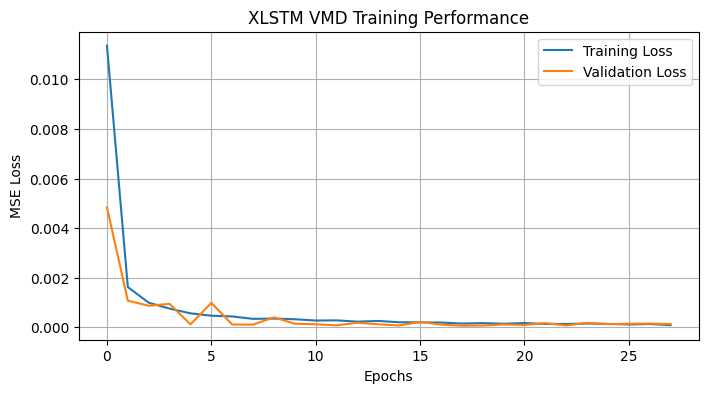

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


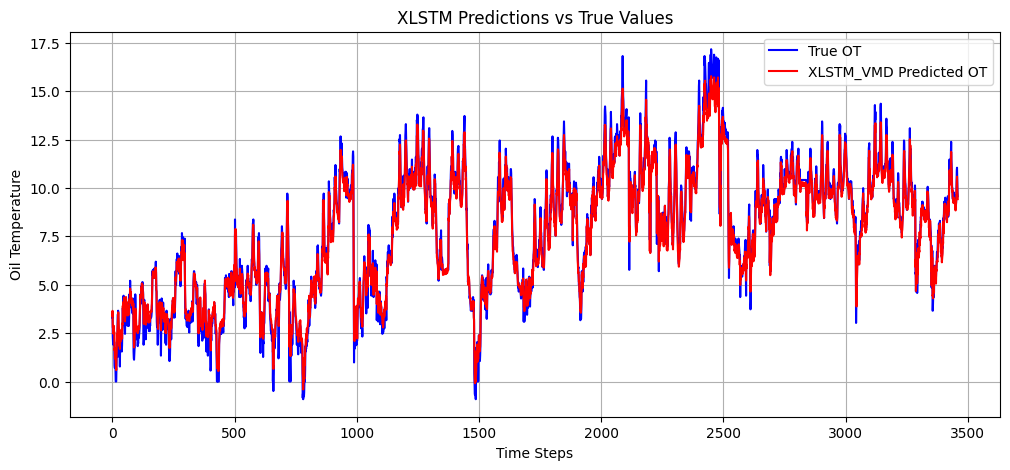

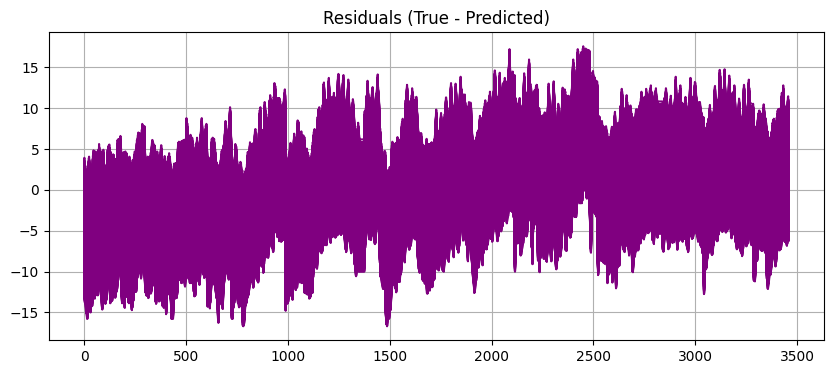

In [11]:
# Load data
y_test_vmd_true,_,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

# -----------------------------
# XLSTM Model Architecture
# -----------------------------

xlstm_model = Sequential([
    Input(shape=(SEQ_LEN, X_train_vmd.shape[-1])),  # automatic feature count
    XLSTM(128, dropout=0.2),
    XLSTM(128, dropout=0.2),
    XLSTM(64, dropout=0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

xlstm_model.compile(optimizer='adam', loss='mse')
xlstm_model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train XLSTM
history_xlstm_vmd = xlstm_model.fit(
    X_train_vmd, y_train_vmd,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_vmd, y_test_vmd),
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history_xlstm_vmd.history['loss'], label='Training Loss')
plt.plot(history_xlstm_vmd.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('XLSTM VMD Training Performance')
plt.legend()
plt.grid(True)
plt.show()

y_pred_xlstm_vmd_scaled = xlstm_model.predict(X_test_vmd)
y_pred_xlstm_vmd_true = scaler_y.inverse_transform(y_pred_xlstm_vmd_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label='True OT', color='blue')
plt.plot(y_pred_xlstm_vmd_true, label='XLSTM_VMD Predicted OT', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('XLSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_xlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


# XLSTM_SiMPLE

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xlstm_3 (XLSTM)                 │ (None, 24, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xlstm_4 (XLSTM)                 │ (None, 24, 128)        │       148,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xlstm_5 (XLSTM)                 │ (None, 24, 64)         │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,353 (1.18 MB)

 Trainable params: 308,353 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0355 - val_loss: 0.0016
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0020 - val_loss: 3.2134e-04
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0015 - val_loss: 3.0807e-04
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0013 - val_loss: 2.1249e-04
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0010 - val_loss: 2.6550e-04
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 8.9225e-04 - val_loss: 2.4626e-04
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 8.1042e-04 - val_loss: 3.2156e-04
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 7.7007e-04 - val_loss: 2.0951e-04
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 7.1150e-04 - val_loss: 2.5138e-04
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.3337e-04 - val_loss: 1.9439e-04
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 6.1643e-04 

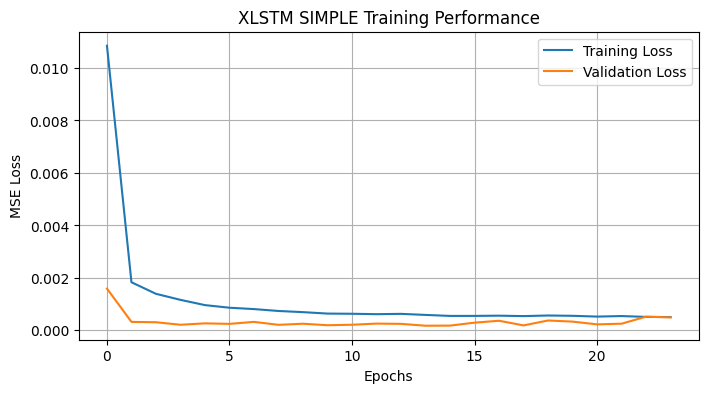

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


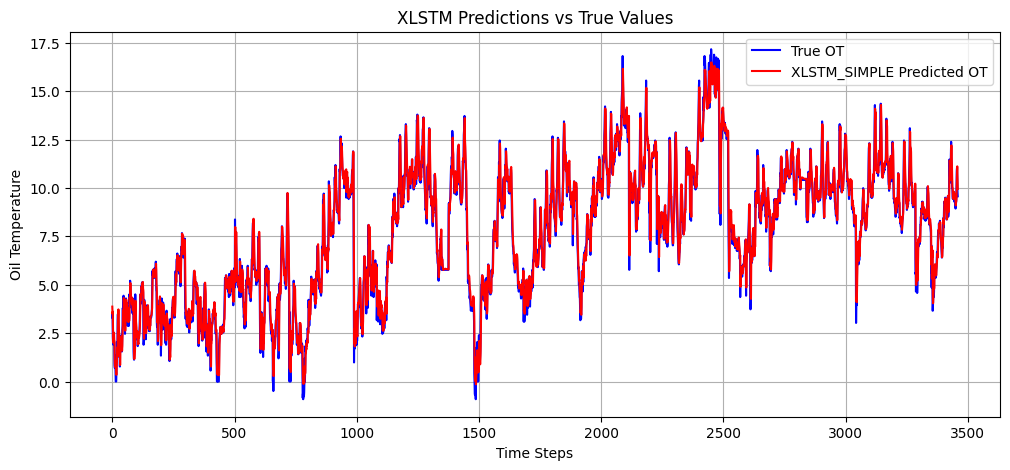

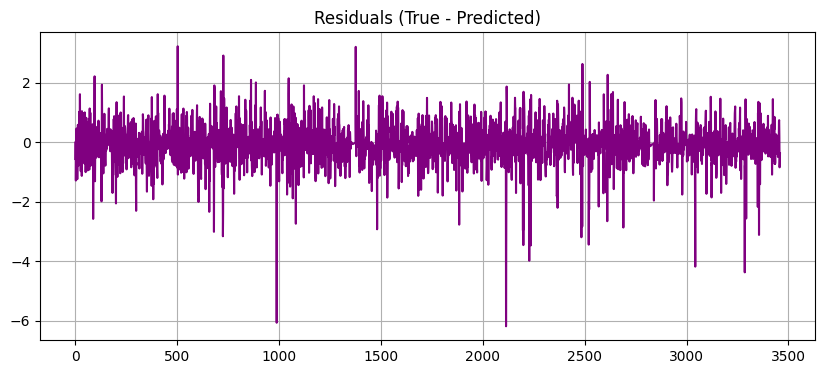

In [12]:
# Load data
_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 

# -----------------------------
# XLSTM Model Architecture
# -----------------------------

xlstm_model_simple = Sequential([
    Input(shape=(SEQ_LEN, X_train_simple.shape[-1])), # automatic feature count
    XLSTM(128, dropout=0.2),
    XLSTM(128, dropout=0.2),
    XLSTM(64, dropout=0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

xlstm_model_simple.compile(optimizer='adam', loss='mse')
xlstm_model_simple.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train XLSTM
history_xlstm_simple = xlstm_model_simple.fit(
    X_train_simple, y_train_simple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test_simple),
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history_xlstm_simple.history['loss'], label='Training Loss')
plt.plot(history_xlstm_simple.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('XLSTM SIMPLE Training Performance')
plt.legend()
plt.grid(True)
plt.show()

y_pred_xlstm_simple_scaled = xlstm_model_simple.predict(X_test_simple)
y_pred_xlstm_simple_true = scaler_y.inverse_transform(y_pred_xlstm_simple_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_xlstm_simple_true, label='XLSTM_SIMPLE Predicted OT', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('XLSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,4))
residuals = y_test_simple_true - y_pred_xlstm_simple_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


#  XLSTM_SelfAttention_VMD

-Type of Attention Used in the this Model

The attention mechanism implemented in the this model is:

- ✅ **Luong Attention (Multiplicative / Dot-Product Attention)**  
A dot-product–based attention mechanism, identifiable through the use of `torch.bmm` or `matmul` operations.

---

- 📌 Main Reference

Luong, Thang, Hieu Pham, and Christopher D. Manning.  
**"Effective Approaches to Attention-based Neural Machine Translation."**  
*Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing (EMNLP)*, 2015.

- **DOI:** `10.18653/v1/D15-1166`  
- **Paper Link (ACL Anthology):** https://aclanthology.org/D15-1166/

---

- 📚 Why the this Attention Matches Luong Attention

- Uses **dot-product scoring** between `hidden` and `encoder_outputs`  
- No linear layers + `tanh` → therefore **not Bahdanau (Additive) Attention**  
- No `Q`, `K`, `V` projections and no `1/sqrt(d)` scaling → therefore **not Transformer Attention**  
- Matches exactly the **Multiplicative (Dot-Product) Attention** described in Luong et al., 2015



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 24, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_6 (XLSTM)     │ (None, 24, 100)   │     44,700 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_7 (XLSTM)     │ (None, 24, 100)   │     90,700 │ xlstm_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_8 (XLSTM)     │ (None, 24, 32)    │     20,320 │ xlstm_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 24, 32)    │      1,056 │ xlstm_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 24, 32)    │      1,056 │ xlstm_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 32)    │          0 │ dense_19[0][0],   │
│ (Attention)         │                   │            │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 64)    │          0 │ xlstm_8[0][0],    │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 64)        │     33,024 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 16)        │      1,040 │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │         17 │ dense_21[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 191,913 (749.66 KB)

 Trainable params: 191,913 (749.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0079 - mae: 0.0466 - val_loss: 9.7346e-04 - val_mae: 0.0293
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 5.8855e-04 - mae: 0.0190 - val_loss: 9.0989e-05 - val_mae: 0.0075
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3.4026e-04 - mae: 0.0144 - val_loss: 7.5338e-05 - val_mae: 0.0066
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 2.8769e-04 - mae: 0.0132 - val_loss: 4.8269e-05 - val_mae: 0.0053
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 2.3084e-04 - mae: 0.0117 - val_loss: 2.3720e-04 - val_mae: 0.0139
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 2.1315e-04 - mae: 0.0115 - val_loss: 2.5983e-04 - val_mae: 0.0149
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 1.9433e-04 - mae: 0.0108 - val_loss: 1.7337e-04 - val_mae: 0.0120
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 2.0091e-04 - mae: 0.0113 - val_loss: 8.5754e-05 - val

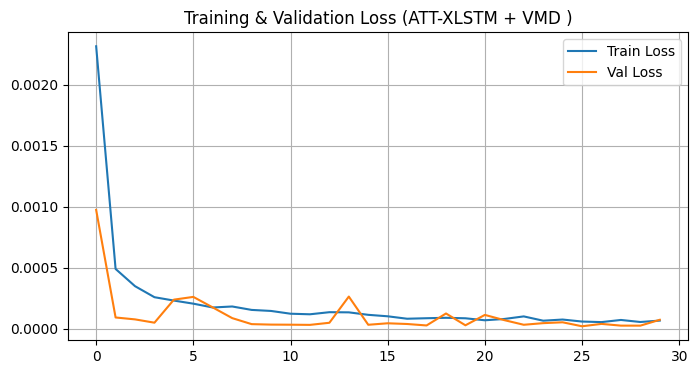

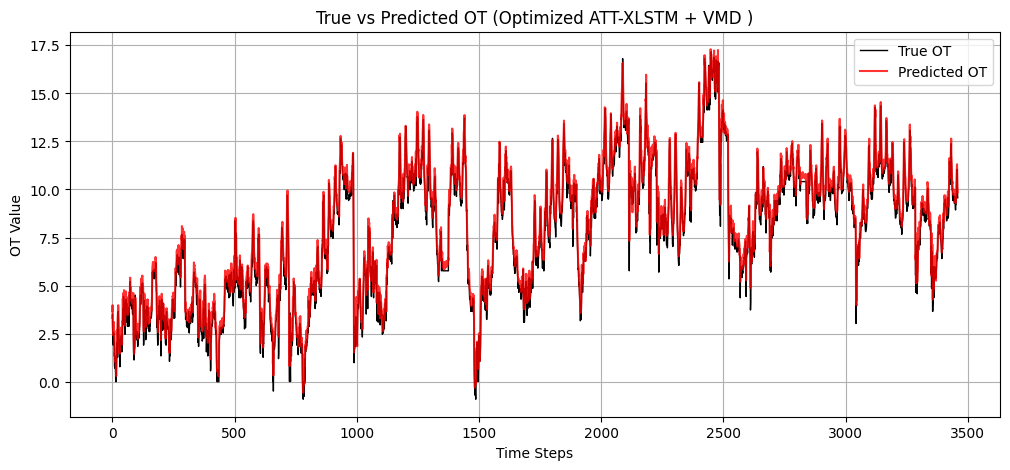

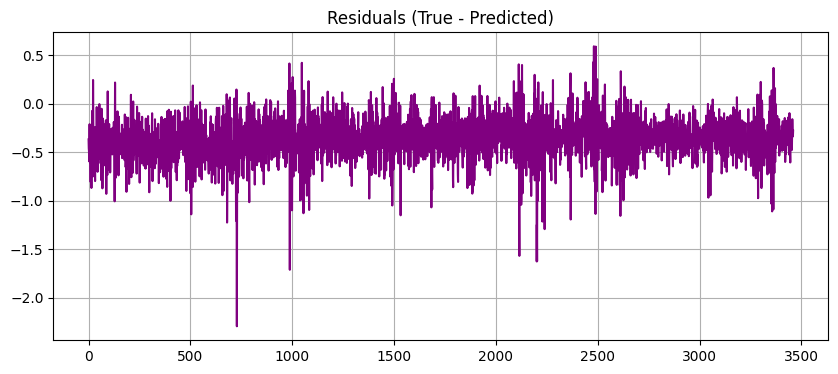

In [13]:
# Get final train/test split (no leakage)
y_test_vmd_true,_,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

input_shape = (SEQ_LEN, X_train_vmd.shape[-1])
inp = Input(shape=input_shape)
x = XLSTM(100, dropout=0.2)(inp)
x = XLSTM(100, dropout=0.2)(x)
x = XLSTM(32, dropout=0.2)(x)

    # Self-Attention Layer
query = Dense(32)(x)
value = Dense(32)(x)
attention_out = Attention()([query, value])

    # Concatenate XLSTM + Attention output
attention_out = Concatenate()([x, attention_out])

    # Decoder LSTM
lstm_dec = LSTM(64, return_sequences=False)(attention_out)
dense_out = Dense(16, activation='relu')(lstm_dec)
final_out = Dense(1)(dense_out)

model_xlstm_attlstm_vmd = Model(inputs=inp, outputs=final_out)
model_xlstm_attlstm_vmd.compile(optimizer='Adam', loss='mse', metrics=['mae'])

model_xlstm_attlstm_vmd.summary()

# Train final model
history_xlstm_attlstm_vmd = model_xlstm_attlstm_vmd.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_xlstm_attlstm_vmd_scaled = model_xlstm_attlstm_vmd.predict(X_test_vmd)
y_pred_xlstm_attlstm_vmd_true = scaler_y.inverse_transform(y_pred_xlstm_attlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_xlstm_attlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_xlstm_attlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-XLSTM + VMD )')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_xlstm_attlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-XLSTM + VMD )')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_xlstm_attlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

# XLSTM + Luong + Multi-Head + Temporal + Cross-Attention + Causal Mask

title: XLSTM-FusionNet: A VMD-Driven Extended LSTM Architecture with Bahdanau, Luong, Multi-Head, and Causal Temporal Attention

- Luong (dot-product) attention
- Multi-Head Attention
- Temporal attention (learned weights over time steps)
- Cross-attention (VMD encoder ↔ optional extra encoder, e.g. short OT history)
- Causal masking (when supported, e.g. MultiHeadAttention)
- XLSTM
- VMD

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 24, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_9 (XLSTM)     │ (None, 24, 64)    │     19,392 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_10 (XLSTM)    │ (None, 24, 64)    │     37,312 │ xlstm_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_11 (XLSTM)    │ (None, 24, 32)    │     14,560 │ xlstm_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_attention  │ (None, 32)        │      1,089 │ xlstm_11[0][0]    │
│ (TemporalAttention) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ luong_attention     │ (None, 24, 128)   │      8,448 │ xlstm_11[0][0],   │
│ (LuongAttention)    │                   │            │ xlstm_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 32)    │     16,800 │ xlstm_11[0][0],   │
│ (MultiHeadAttentio… │                   │            │ xlstm_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 24, 32)    │          0 │ temporal_attenti… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention     │ (None, 24, 32)    │     10,656 │ xlstm_11[0][0],   │
│ (CrossAttention)    │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 24, 256)   │          0 │ xlstm_11[0][0],   │
│ (Concatenate)       │                   │            │ luong_attention[… │
│                     │                   │            │ multi_head_atten… │
│                     │                   │            │ repeat_vector[0]… │
│                     │                   │            │ cross_attention[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ (None, 100)       │    142,800 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 32)        │      3,232 │ lstm_23[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │         33 │ dense_30[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 254,322 (993.45 KB)

 Trainable params: 254,322 (993.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0168 - mae: 0.0636 - val_loss: 2.5561e-04 - val_mae: 0.0124
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 7.1026e-04 - mae: 0.0208 - val_loss: 1.2086e-04 - val_mae: 0.0085
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 5.0348e-04 - mae: 0.0174 - val_loss: 1.8757e-04 - val_mae: 0.0113
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 4.0794e-04 - mae: 0.0157 - val_loss: 9.6078e-05 - val_mae: 0.0077
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 2.8814e-04 - mae: 0.0133 - val_loss: 5.6387e-05 - val_mae: 0.0057
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 2.4201e-04 - mae: 0.0121 - val_loss: 1.4300e-04 - val_mae: 0.0102
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 2.1756e-04 - mae: 0.0116 - val_loss: 8.4750e-05 - val_mae: 0.0073
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 1.5322e-04 - mae: 0.0096 - val_loss: 7.3681e-05 - val

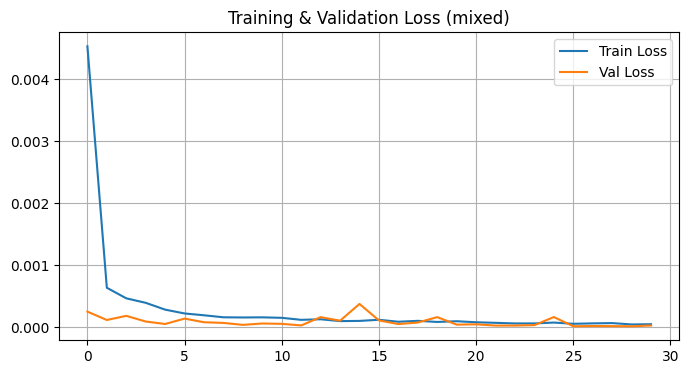

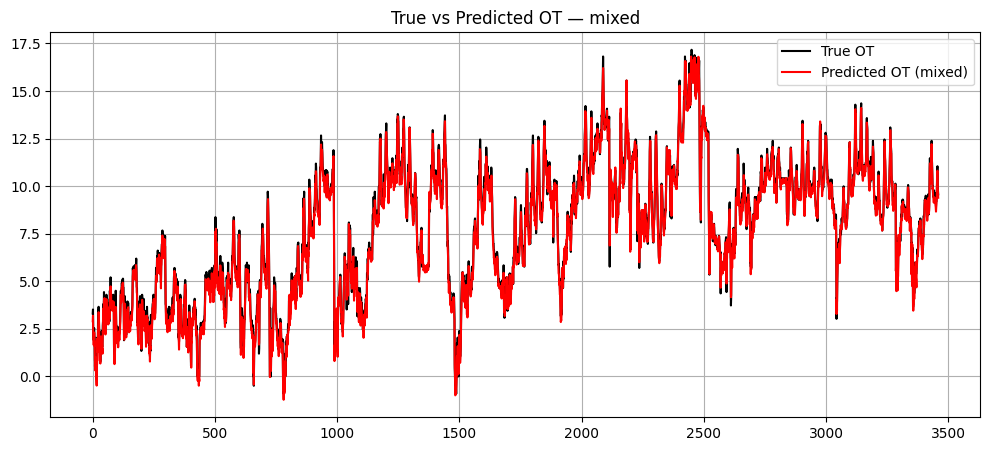

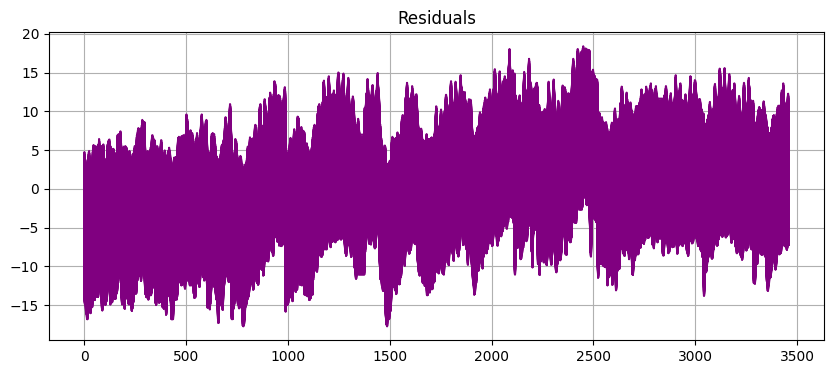

In [14]:
# =========================================================
# 📌 6 — THE FINAL mehdiy_v2 MODEL
# =========================================================
def build_mehdiy_v2(input_shape, lstm2_units=32):

    seq_len = input_shape[0]
    inp = Input(shape=input_shape)

    # -------------------------------
    # (A) XLSTM BLOCKS
    # -------------------------------
    x = XLSTM(64, dropout=0.2)(inp)
    x = XLSTM(64, dropout=0.2)(x)
    x = XLSTM(32, dropout=0.2)(x)

    # =====================================================
    # (B) Attention Upgrade Pack
    # =====================================================

    # -------------------------------
    # 1) LUONG Attention
    # -------------------------------
    luong = LuongAttention(128)(x, x)

    # -------------------------------
    # 2) Multi-Head Attention with causal mask
    # -------------------------------
    mask = causal_mask(seq_len)
    mha = MultiHeadAttention(num_heads=4, key_dim=32)(x, x, attention_mask=mask)

    # -------------------------------
    # 3) Temporal Attention
    # -------------------------------
    temp_context = TemporalAttention(32)(x)
    temp_context = RepeatVector(seq_len)(temp_context)

    # -------------------------------
    # 4) Cross Attention (input → XLSTM)
    # -------------------------------
    cross = CrossAttention(num_heads=4, key_dim=32)(x, inp)

    # -------------------------------
    # COMBINE ALL ATTENTIONS
    # -------------------------------
    att_concat = Concatenate()([x, luong, mha, temp_context, cross])

    # -------------------------------
    # Decoder
    # -------------------------------
    lstm_dec = LSTM(lstm2_units, return_sequences=False)(att_concat)
    dense = Dense(32, activation='relu')(lstm_dec)
    out = Dense(1)(dense)

    return Model(inputs=inp, outputs=out)


# =================================================================
# 📌 7 — Training (same style as your mehdiy code)
# =================================================================
# Final non-leaking train/test
y_test_vmd_true,_,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

input_shape = (SEQ_LEN, X_train_vmd.shape[-1])
model_mixed = build_mehdiy_v2(input_shape=input_shape, lstm2_units=100)

model_mixed.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_mixed.summary()

history_model_mixed = model_mixed.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predictions
y_pred_model_mixed_scaled = model_mixed.predict(X_test_vmd)
y_pred_model_mixed_true = scaler_y.inverse_transform(y_pred_model_mixed_scaled)


# =================================================================
# 📌 8 — PLOTTING (same format as mehdiy)
# =================================================================
plt.figure(figsize=(8, 4))
plt.plot(history_model_mixed.history['loss'], label='Train Loss')
plt.plot(history_model_mixed.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (mixed)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label='True OT', color='black')
plt.plot(y_pred_model_mixed_true, label='Predicted OT (mixed)', color='red')
plt.title('True vs Predicted OT — mixed')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true - y_pred_model_mixed_true.flatten()
plt.plot(residuals, color='purple')
plt.title('Residuals')
plt.grid(True); plt.show()


# Compare Models

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_Attlstm_vmd, rmse_Attlstm_vmd_ga, mae_Attlstm_vmd_ga, r2_attlstm_vmd_ga = compute_metrics(y_pred_attlstm_vmd_true, y_test_vmd_true)
mse_Bidirectional_Lstm_simple, rmse_Lstm_Bidirectional_simple, mae_Lstm_Bidirectional_simple, r2_Lstm_Bidirectional_simple = compute_metrics(y_pred_Bidirectional_lstm_simple_true, y_test_simple_true)
mse_Attlstm_simple, rmse_Attlstm_simple_ga, mae_Attlstm_simple_ga, r2_attlstm_simple_ga = compute_metrics(y_pred_attlstm_simple_true, y_test_simple_true)
mse_Lstm_vmd, rmse_Lstm_vmd, mae_Lstm_vmd, r2_Lstm_vmd = compute_metrics(y_pred_lstm_vmd_true, y_test_vmd_true)
mse_XLstm_vmd, rmse_XLstm_vmd, mae_XLstm_vmd, r2_XLstm_vmd = compute_metrics(y_pred_xlstm_vmd_true, y_test_vmd_true)
mse_XLstm_simple, rmse_XLstm_simple, mae_XLstm_simple, r2_XLstm_simple = compute_metrics(y_pred_xlstm_simple_true, y_test_simple_true)
mse_AttLstm_XLstm_vmd, rmse_AttLstm_XLstm_vmd, mae_AttLstm_XLstm_vmd, r2_AttLstm_XLstm_vmd = compute_metrics(y_pred_xlstm_attlstm_vmd_true, y_test_vmd_true)
mse_mixed, rmse_mixed, mae_mixed, r2_mixed = compute_metrics(y_pred_model_mixed_true, y_test_vmd_true)

# Print comparison
print("📈 Model Performance Comparison")
print(f"ATT-LSTM-VMD: MSE={mse_Attlstm_vmd:.4f}, RMSE={rmse_Attlstm_vmd_ga:.4f}, MAE={mae_Attlstm_vmd_ga:.4f}, R²={r2_attlstm_vmd_ga:.4f}")
print(f"Bidirectional_Lstm_Simple: MSE={mse_Bidirectional_Lstm_simple:.4f}, RMSE={rmse_Lstm_Bidirectional_simple:.4f}, MAE={mae_Lstm_Bidirectional_simple:.4f}, R²={r2_Lstm_Bidirectional_simple:.4f}")
print(f"Attlstm_Simple: MSE={mse_Attlstm_simple:.4f}, RMSE={rmse_Attlstm_simple_ga:.4f}, MAE={mae_Attlstm_simple_ga:.4f}, R²={r2_attlstm_simple_ga:.4f}")
print(f"Lstm_vmd: MSE={mse_Lstm_vmd:.4f}, RMSE={rmse_Lstm_vmd:.4f}, MAE={mae_Lstm_vmd:.4f}, R²={r2_Lstm_vmd:.4f}")
print(f"XLstm_vmd: MSE={mse_XLstm_vmd:.4f}, RMSE={rmse_XLstm_vmd:.4f}, MAE={mae_XLstm_vmd:.4f}, R²={r2_XLstm_vmd:.4f}")
print(f"XLstm_simple: MSE={mse_XLstm_simple:.4f}, RMSE={rmse_XLstm_simple:.4f}, MAE={mae_XLstm_simple:.4f}, R²={r2_XLstm_simple:.4f}")
print(f"AttLSTM_XLSTM_VMD: MSE={mse_AttLstm_XLstm_vmd:.4f}, RMSE={rmse_AttLstm_XLstm_vmd:.4f}, MAE={mae_AttLstm_XLstm_vmd:.4f}, R²={r2_AttLstm_XLstm_vmd:.4f}")
print(f"MIXED: MSE={mse_mixed:.4f}, RMSE={rmse_mixed:.4f}, MAE={mae_mixed:.4f}, R²={r2_mixed:.4f}")


📈 Model Performance Comparison
ATT-LSTM-VMD: MSE=0.0694, RMSE=0.2634, MAE=0.2005, R²=0.9944
Bidirectional_Lstm_Simple: MSE=0.4199, RMSE=0.6480, MAE=0.4433, R²=0.9640
Attlstm_Simple: MSE=0.4520, RMSE=0.6723, MAE=0.4685, R²=0.9593
Lstm_vmd: MSE=0.4455, RMSE=0.6675, MAE=0.6250, R²=0.9603
XLstm_vmd: MSE=0.1652, RMSE=0.4064, MAE=0.3127, R²=0.9836
XLstm_simple: MSE=0.4404, RMSE=0.6636, MAE=0.4588, R²=0.9621
AttLSTM_XLSTM_VMD: MSE=0.1805, RMSE=0.4249, MAE=0.3736, R²=0.9843
MIXED: MSE=0.0816, RMSE=0.2857, MAE=0.2274, R²=0.9932


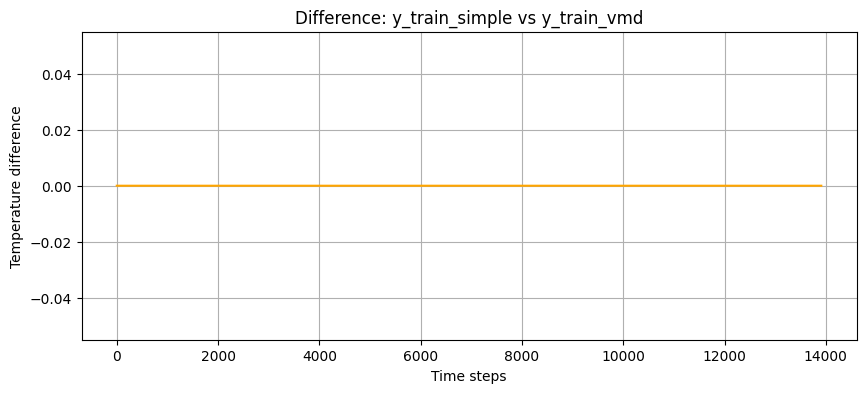

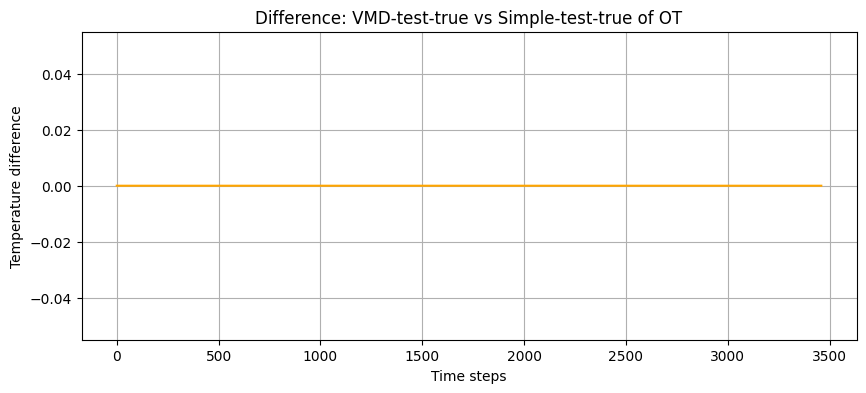

In [16]:
diff = y_train_simple - y_train_vmd
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: y_train_simple vs y_train_vmd')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()

y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple)
diff = y_test_simple_true - y_test_vmd_true
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: VMD-test-true vs Simple-test-true of OT')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()